In [37]:

!ls -l /content/datason.yaml

# quick view
!sed -n '1,200p' /content/datason.yaml


-rw-r--r-- 1 root root 214 Oct 19 04:41 /content/datason.yaml
train: /content/drive/MyDrive/disord/disord/train/images
val: /content/drive/MyDrive/disord/disord/valid/images
test: /content/drive/MyDrive/disord/disord/test/images

nc: 3
names: ['Normal','Reversal','Corrected']

In [38]:
from ultralytics import YOLO
import cv2
import os

# Model ve test resmi yolu
MODEL_PATH = "/content/best.pt"
IMAGE_PATH = "/content/train_0019.png"  # test resmini buraya koy
DATA_YAML_PATH = "/content/datason.yaml"

# Modeli yükle
model = YOLO(MODEL_PATH)
print("Model yüklendi!")


Model yüklendi!


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/tasks.py:732: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")


In [39]:
# Tahmin (inference)
results = model.predict(
    source=IMAGE_PATH,
    save=True,
    imgsz=640
)
boxes = results[0].boxes.xyxy.cpu().numpy()
print("Tahmin tamamlandı!")



image 1/1 /content/train_0019.png: 640x640 22 Normals, 19 Reversals, 19 Correcteds, 1111.0ms
Speed: 4.3ms preprocess, 1111.0ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict3
Tahmin tamamlandı!


In [40]:
def line_analysis(boxes, tolerance=5):
    """
    Satır hizalamasındaki sapmayı hesaplar.
    :param boxes: [[x1, y1, x2, y2]]
    :param tolerance: küçük farklar için tolerans
    :return: line_error, mean_y
    """
    if len(boxes) == 0:
        return 0, 0

    boxes = sorted(boxes, key=lambda x: x[0])
    y_centers = np.array([(box[1] + box[3]) / 2 for box in boxes])
    mean_y = int(np.mean(y_centers))
    deviations = np.abs(y_centers - mean_y)
    line_error = np.mean(deviations) / (tolerance + np.mean(y_centers))

    return round(line_error, 4), mean_y  # iki değer döndür


In [41]:
import cv2
import matplotlib.pyplot as plt

def visualize_boxes(image_path, boxes, mean_line):
    """
    YOLO kutularını ve ortalama hizayı görselleştirir
    """
    img = cv2.imread(image_path)
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Ortalama çizgi
    cv2.line(img, (0, mean_line), (img.shape[1], mean_line), (0, 0, 255), 2)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


In [42]:
import cv2
import matplotlib.pyplot as plt
import random

def visualize_all_rows(image_path, all_rows, show_mean_line=True):
    """
    Tüm satırları tek resim üzerinde gösterir
    :param image_path: resim yolu
    :param all_rows: [[kutular satır1], [kutular satır2], ...]
    :param show_mean_line: ortalama çizgileri göster
    """
    img = cv2.imread(image_path)

    for row_boxes in all_rows:
        # Satır için rastgele renk seç (kutular için)
        color = tuple(np.random.randint(0, 255, 3).tolist())

        # Her kutuyu çiz
        for box in row_boxes:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        # Ortalama çizgi
        if show_mean_line:
            _, mean_line = line_analysis(row_boxes)
            cv2.line(img, (0, mean_line), (img.shape[1], mean_line), color, 2)

    # Tek defada göster
    plt.figure(figsize=(12,8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


📏 Satır 1 Line Alignment Error: 0.0020000000949949026
📏 Satır 2 Line Alignment Error: 0.007600000128149986
📏 Satır 3 Line Alignment Error: 0.0012000000569969416
📏 Satır 4 Line Alignment Error: 0.0031999999191612005
📏 Satır 5 Line Alignment Error: 0.00039999998989515007


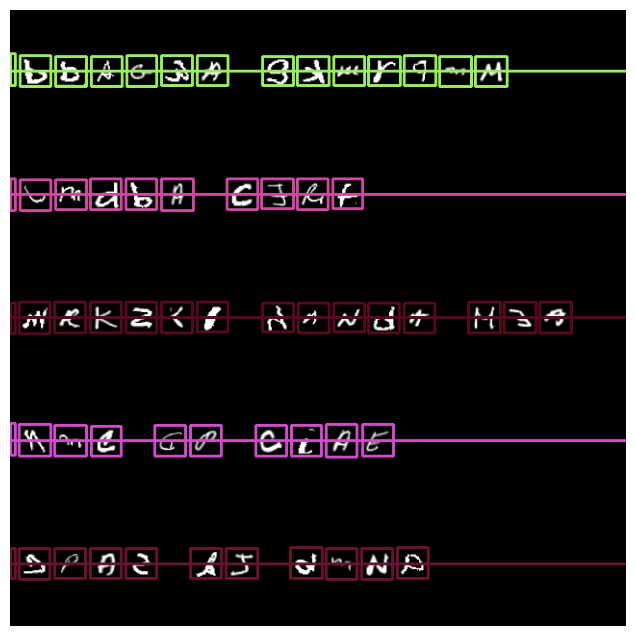

In [43]:
# Satırları grupla (DBSCAN veya basit y-sıralama)
rows = group_boxes_by_lines(boxes, eps=15)

# Her satır için line_error hesapla
for i, row_boxes in enumerate(rows):
    error, _ = line_analysis(row_boxes)
    print(f"📏 Satır {i+1} Line Alignment Error: {error}")

# Tek resim üzerinde tüm satırları göster
visualize_all_rows(image_path, rows)
